## 각 회사별로 요일을 나누어 분석, 미팅 발표에 제출한 결과입니다.

#### 1. 모듈과 데이터를 불러옵니다.

In [1]:
from _element import feature_control as ft_c

In [2]:
from _usecase import algorithm_prophet as prpt

In [3]:
from _element import calculations as calc

In [4]:
import pandas as pd

In [5]:
from datetime import datetime

In [6]:
from _element import varr

In [7]:
INPUT_FILENAME= 'KPP일별투입(10_17)_withcompanycode.xlsx'

In [8]:
df_raw= ft_c.xlsx_opener(varr.PJ_DIR+varr.DF_DIR, INPUT_FILENAME)

In [9]:
df_temp= ft_c.xlsx_opener(varr.PJ_DIR+varr.TEMP_DATA_DIR, 'temp_data_merged.xlsx')

#### 2. 데이터를 전처리하고 물동량 데이터와 기후 데이터를 합칩니다.

In [10]:
y_col= df_raw.columns.values.tolist()

In [11]:
try:
    y_col.remove('ds')
except ValueError:
    pass

In [12]:
y_col

[227645, 230054, 247467, 265812, 269255, 283639]

In [13]:
x_col= df_temp.columns.values.tolist()

In [14]:
x_col

['ds', 'temp_max', 'temp_min', 'rain_amount']

In [15]:
df_raw['ds']= pd.to_datetime(df_raw['ds'], box=True, format= '%Y/%m/%d', exact=True)

In [16]:
df_temp['ds']= pd.to_datetime(df_temp['ds'], box=True, format= '%Y/%m/%d', exact=True)

In [17]:
df_raw= pd.merge(df_raw, df_temp, how='inner', on='ds')

In [18]:
df_raw.head()

ds  227645  230054  247467  265812  269255  283639   temp_max  \
0 2010-07-01     512       0    2496    1248    1264     746  30.500000   
1 2010-07-02     992       0    2800    1140     768     681  25.799999   
2 2010-07-03     512       0    1024     992     768     899  25.600000   
3 2010-07-04       0       0       0       0       0       0  29.700001   
4 2010-07-05    1204       0    2496    1056    1024     459  30.600000   

    temp_min  rain_amount  
0  24.900000          0.0  
1  22.700001         70.0  
2  22.600000          1.0  
3  23.100000          0.0  
4  21.799999          0.0

#### 3. 데이터를 요일별로 나누고 prophet 라이브러리를 활용하여 분석합니다.

In [19]:
df_weekday_0= df_raw.loc[df_raw.ds.apply(lambda x: x.weekday())==0]
df_weekday_1= df_raw.loc[df_raw.ds.apply(lambda x: x.weekday())==1]
df_weekday_2= df_raw.loc[df_raw.ds.apply(lambda x: x.weekday())==2]
df_weekday_3= df_raw.loc[df_raw.ds.apply(lambda x: x.weekday())==3]
df_weekday_4= df_raw.loc[df_raw.ds.apply(lambda x: x.weekday())==4]
df_weekday_5= df_raw.loc[df_raw.ds.apply(lambda x: x.weekday())==5]
df_weekday_6= df_raw.loc[df_raw.ds.apply(lambda x: x.weekday())==6]

In [20]:
result_dict= {}
for y in y_col:
    result_dict[y]= {
                    'mon': prpt.Bayseian2(df_weekday_0, varr.FORECASTDAY, y, x_col, 'week'),\
                    'tue': prpt.Bayseian2(df_weekday_1, varr.FORECASTDAY, y, x_col, 'week'),\
                    'wed': prpt.Bayseian2(df_weekday_2, varr.FORECASTDAY, y, x_col, 'week'),\
                    'thu': prpt.Bayseian2(df_weekday_3, varr.FORECASTDAY, y, x_col, 'week'),\
                    'pri': prpt.Bayseian2(df_weekday_4, varr.FORECASTDAY, y, x_col, 'week'),\
                    'sat': prpt.Bayseian2(df_weekday_5, varr.FORECASTDAY, y, x_col, 'week'),\
                    'sun': prpt.Bayseian2(df_weekday_6, varr.FORECASTDAY, y, x_col, 'week'),\
                    }

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_

In [21]:
merged_dict={}
for y in y_col:
    merged_dict[y]={'future': 
                    pd.concat([result_dict[y]['mon']['future'],\
                              result_dict[y]['tue']['future'],\
                              result_dict[y]['wed']['future'],\
                              result_dict[y]['thu']['future'],\
                              result_dict[y]['pri']['future'],\
                              result_dict[y]['sat']['future'],\
                              result_dict[y]['sun']['future']],\
                              axis= 0).sort_values(by='ds', axis=0),
                   'forecastProphetTable':
                    pd.concat([result_dict[y]['mon']['forecastProphetTable'],\
                              result_dict[y]['tue']['forecastProphetTable'],\
                              result_dict[y]['wed']['forecastProphetTable'],\
                              result_dict[y]['thu']['forecastProphetTable'],\
                              result_dict[y]['pri']['forecastProphetTable'],\
                              result_dict[y]['sat']['forecastProphetTable'],\
                              result_dict[y]['sun']['forecastProphetTable']],\
                              axis= 0).sort_values(by='ds', axis=0)
                   }

* 예측 결과와 오차율입니다.

In [22]:
forecast_dict={}
print(INPUT_FILENAME)
for y in y_col:
    merged_dict[y]['future']['ds']= pd.to_datetime(merged_dict[y]['future']['ds'], box=True, format= '%Y/%m/%d', exact=True)
    merged_dict[y]['forecastProphetTable']['ds']= pd.to_datetime(merged_dict[y]['forecastProphetTable']['ds'], box=True, format= '%Y/%m/%d', exact=True)
    forecast_dict[y]= prpt.extract_info_from(merged_dict[y]['future'], merged_dict[y]['forecastProphetTable'], varr.FORECASTDAY)
    forecast_dict[y]['result_df']= pd.merge(forecast_dict[y]['result_df'], df_raw[['ds', y]], how='inner', on='ds')
    print('RMSE with segment '+str(y)+': '+str(calc.rms_error(forecast_dict[y]['result_df'][y], forecast_dict[y]['result_df']['yhat'])))
    print('MAPE with segment '+str(y)+': '+str(calc.map_error(forecast_dict[y]['result_df'][y], forecast_dict[y]['result_df']['yhat'])))
    print('MAPE_with_std with segment '+str(y)+': '+str(calc.map_error_with_std(forecast_dict[y]['result_df'][y], forecast_dict[y]['result_df']['yhat'])))
    print('MAPE_div_std with segment '+str(y)+': '+str(calc.map_error_div_std(forecast_dict[y]['result_df'][y], forecast_dict[y]['result_df']['yhat'])))
    print('sMAPE of company code '+str(y)+': '+str(calc.smap_error(forecast_dict[y]['result_df'][y], forecast_dict[y]['result_df']['yhat'])))
    print(forecast_dict[y]['result_df'].head())
    ft_c.save_as_xlsx(varr.PJ_DIR+varr.DF_DIR, forecast_dict[y]['result_df'], INPUT_FILENAME, '_seg'+str(y)+'withweekday')
    print('\n')

KPP일별투입(10_17)_withcompanycode.xlsx
RMSE with segment 227645: 374.313027751
MAPE with segment 227645: inf
MAPE_with_std with segment 227645: 35.7298971097
MAPE_div_std with segment 227645: 74.9438481133
sMAPE of company code 227645: 10.5081396384
          ds   temp_max  temp_min  rain_amount         yhat  227645
0 2017-11-01  17.299999      13.4          0.0  1900.245657    2048
1 2017-11-02  18.000000      14.0          1.6  1885.753761    1792
2 2017-11-03  15.700000       4.5          0.6  1394.514796    1280
3 2017-11-04  12.800000       3.2          0.0   573.034977     768
4 2017-11-05  14.200000       7.3          0.0    -8.431749       0


c:\Studying\Project_Nextop\nextop-engine\nextop_engine\_element\calculations.py:11: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100




RMSE with segment 230054: 515.689327485
MAPE with segment 230054: inf
MAPE_with_std with segment 230054: 67.7849355464
MAPE_div_std with segment 230054: 65.9168934332
sMAPE of company code 230054: 45.6669009294
          ds   temp_max  temp_min  rain_amount        yhat  230054
0 2017-11-01  17.299999      13.4          0.0  276.241684    1152
1 2017-11-02  18.000000      14.0          1.6  256.790546     288
2 2017-11-03  15.700000       4.5          0.6  304.968351     864
3 2017-11-04  12.800000       3.2          0.0  684.768754     288
4 2017-11-05  14.200000       7.3          0.0   -8.285876       0


RMSE with segment 247467: 633.052077843
MAPE with segment 247467: inf
MAPE_with_std with segment 247467: 41.8814585926
MAPE_div_std with segment 247467: 80.4428223308
sMAPE of company code 247467: 15.4751181996
          ds   temp_max  temp_min  rain_amount         yhat  247467
0 2017-11-01  17.299999      13.4          0.0  2450.658496    2048
1 2017-11-02  18.000000      14.0   

c:\Studying\Project_Nextop\nextop-engine\nextop_engine\_element\calculations.py:11: RuntimeWarning: invalid value encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100




RMSE with segment 283639: 379.675054223
MAPE with segment 283639: nan
MAPE_with_std with segment 283639: 47.9619434881
MAPE_div_std with segment 283639: 79.5100071708
sMAPE of company code 283639: 23.0040444224
          ds   temp_max  temp_min  rain_amount         yhat  283639
0 2017-11-01  17.299999      13.4          0.0   831.177161     425
1 2017-11-02  18.000000      14.0          1.6   797.823601    1411
2 2017-11-03  15.700000       4.5          0.6  1001.665848     762
3 2017-11-04  12.800000       3.2          0.0  1011.468159    1453
4 2017-11-05  14.200000       7.3          0.0     0.000000       0




* 그래프입니다.

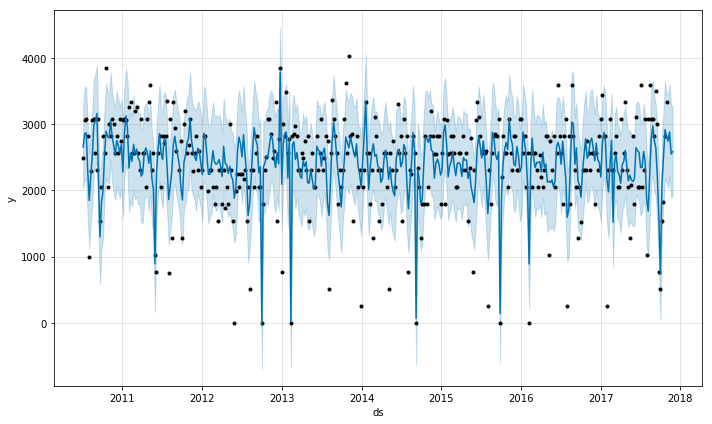

In [38]:
result_dict[247467]['mon']['model'].plot(result_dict[247467]['mon']['forecastProphetTable'])

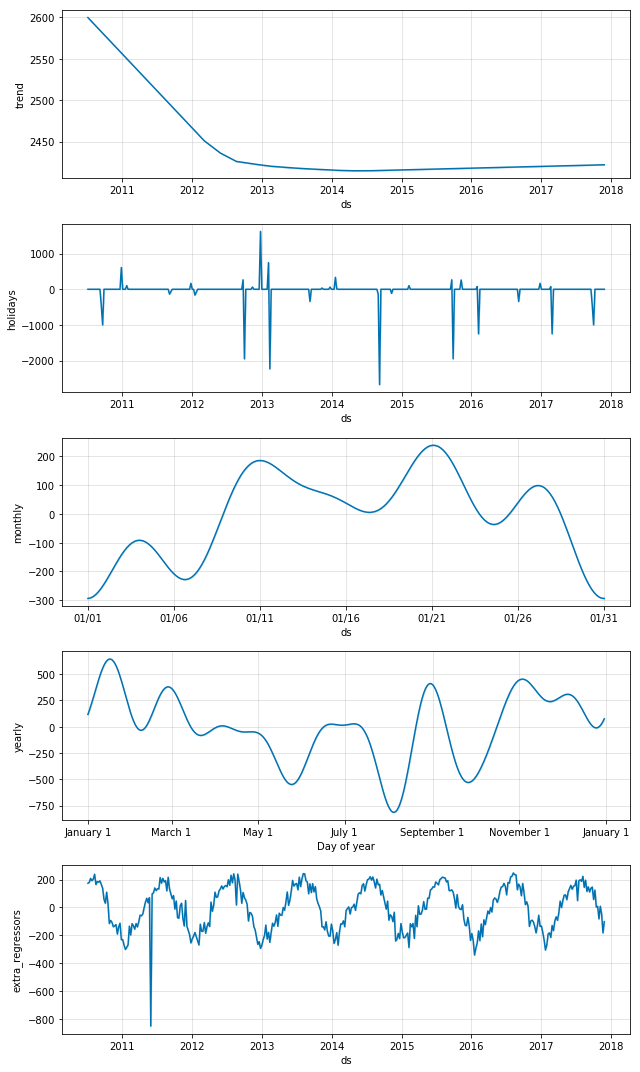

In [39]:
result_dict[247467]['mon']['model'].plot_components(result_dict[247467]['mon']['forecastProphetTable'])

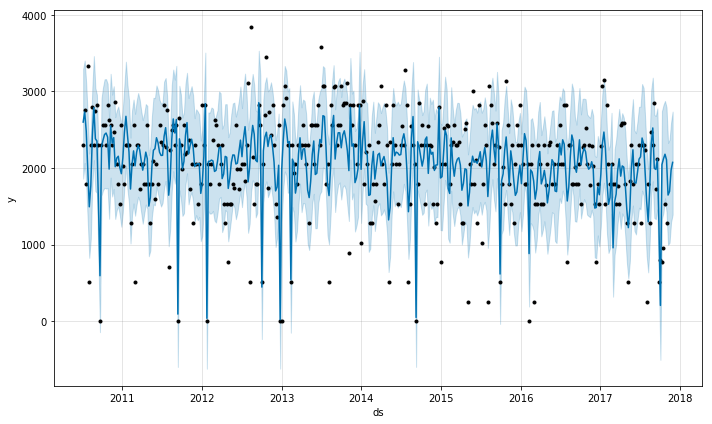

In [40]:
result_dict[247467]['tue']['model'].plot(result_dict[247467]['tue']['forecastProphetTable'])

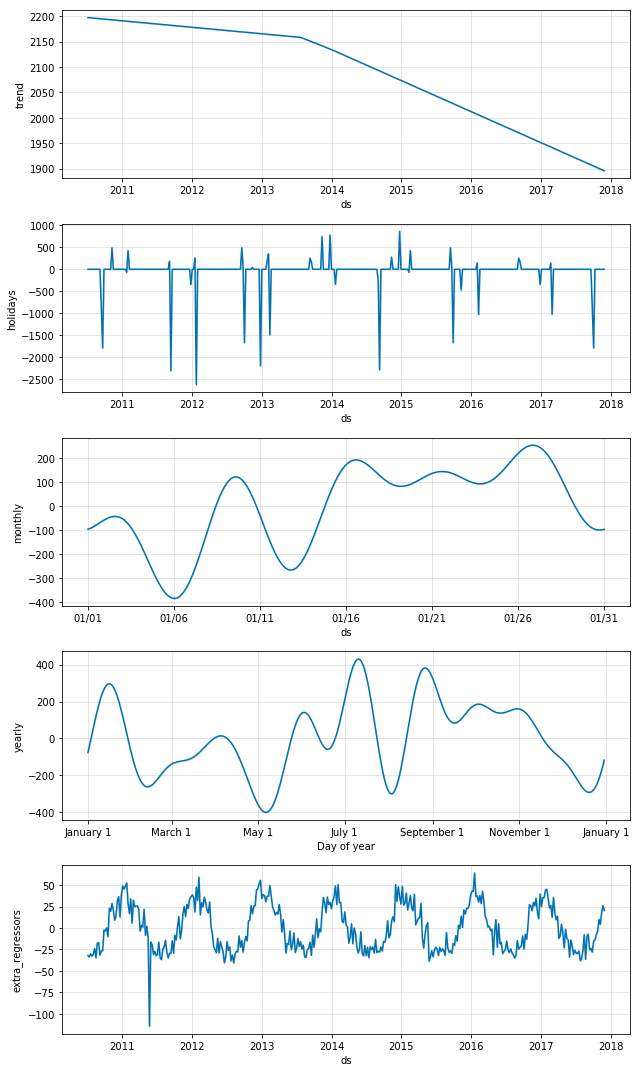

In [41]:
result_dict[247467]['tue']['model'].plot_components(result_dict[247467]['tue']['forecastProphetTable'])

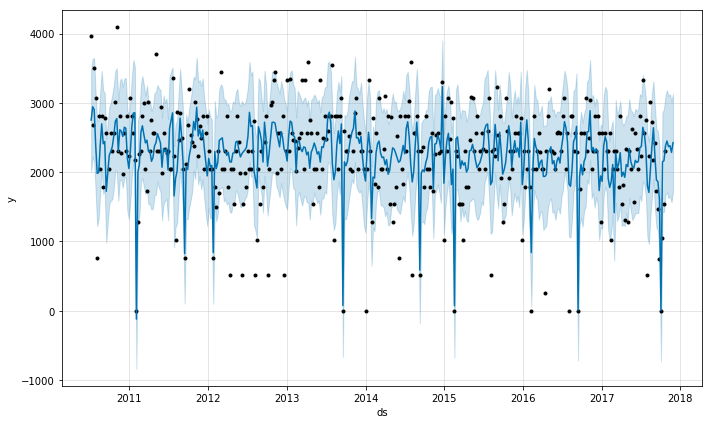

In [42]:
result_dict[247467]['wed']['model'].plot(result_dict[247467]['wed']['forecastProphetTable'])

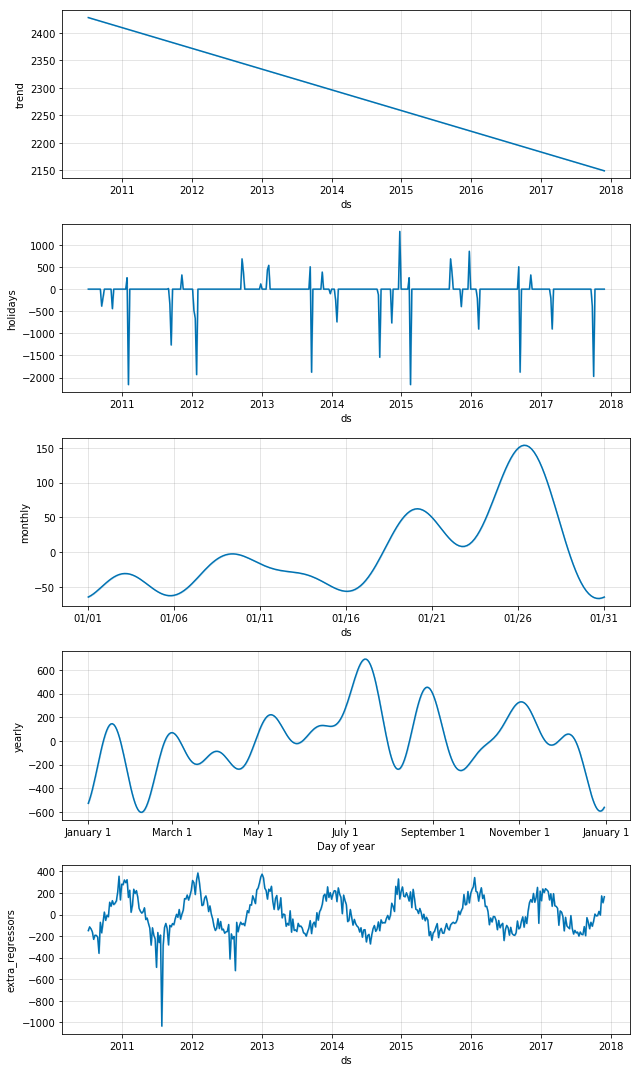

In [43]:
result_dict[247467]['wed']['model'].plot_components(result_dict[247467]['wed']['forecastProphetTable'])

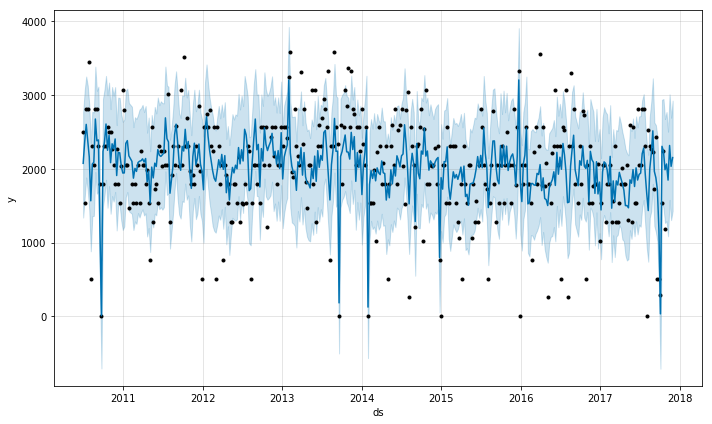

In [44]:
result_dict[247467]['thu']['model'].plot(result_dict[247467]['thu']['forecastProphetTable'])

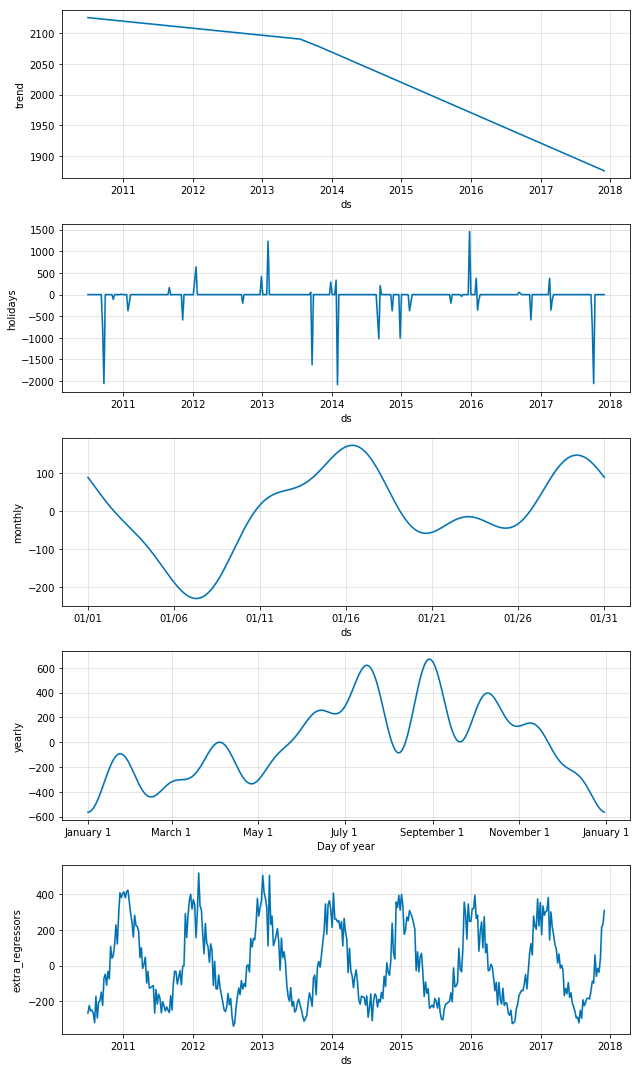

In [45]:
result_dict[247467]['thu']['model'].plot_components(result_dict[247467]['thu']['forecastProphetTable'])

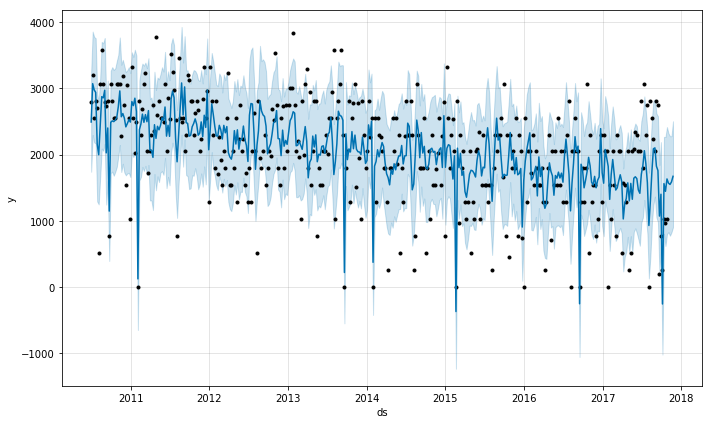

In [46]:
result_dict[247467]['pri']['model'].plot(result_dict[247467]['pri']['forecastProphetTable'])

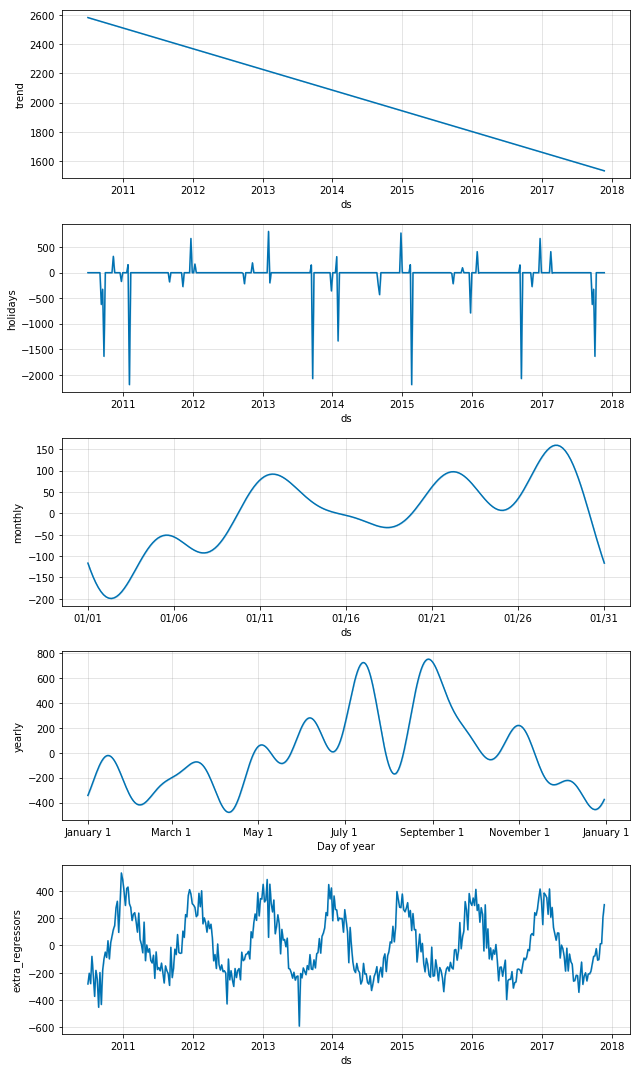

In [47]:
result_dict[247467]['pri']['model'].plot_components(result_dict[247467]['pri']['forecastProphetTable'])

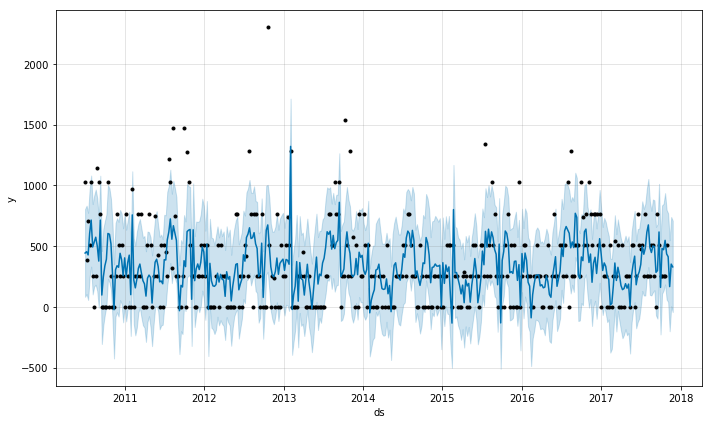

In [48]:
result_dict[247467]['sat']['model'].plot(result_dict[247467]['sat']['forecastProphetTable'])

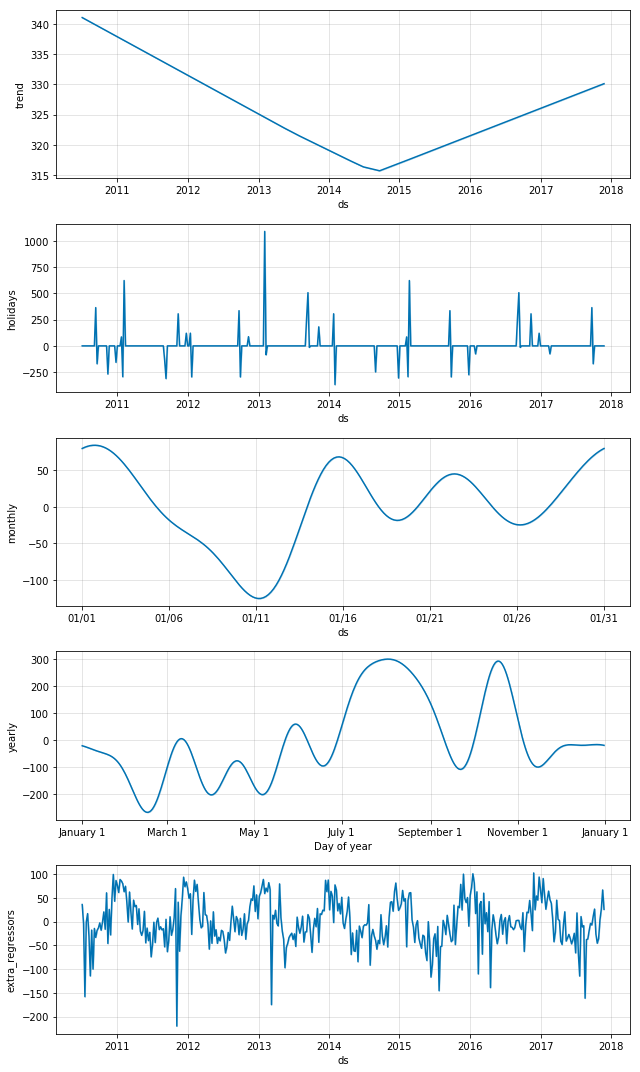

In [49]:
result_dict[247467]['sat']['model'].plot_components(result_dict[247467]['sat']['forecastProphetTable'])

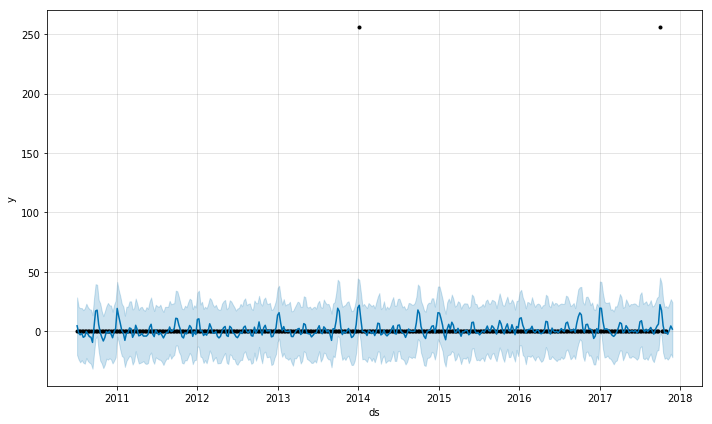

In [50]:
result_dict[247467]['sun']['model'].plot(result_dict[247467]['sun']['forecastProphetTable'])

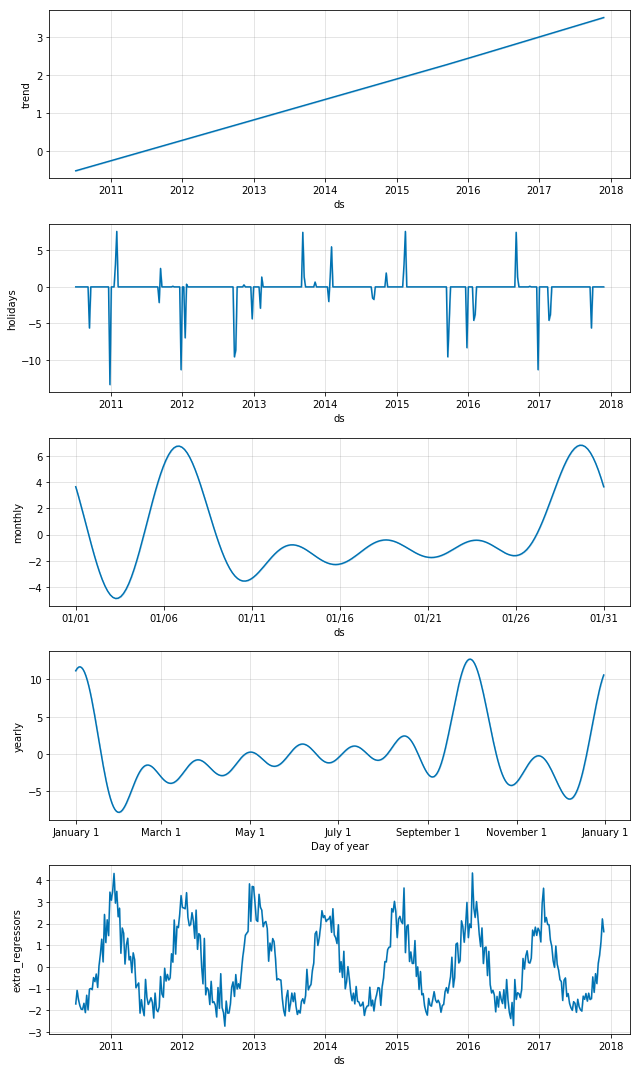

In [51]:
result_dict[247467]['sun']['model'].plot_components(result_dict[247467]['sun']['forecastProphetTable'])